# Playing around with the trees

In [1]:
import os, sys
import numpy as np
import uproot
import pandas as pd

In [2]:
indir = '/mnt/d/work/GitHub/VLLSearch-Run3/AnaCodes/prachu/TreeMaker/test_outputs'

def read_file_into_df(name, truth):
    file = uproot.open(f'{indir}/{name}')
    tree = file['Events']
    branches = ['nlep', 'lep0_pt']
    awkarray = tree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['truth'] = truth
    return df

In [3]:
df_bkg = read_file_into_df('tree_dy.root', 0)
df_sig = read_file_into_df('tree_vlld_ele_800.root', 1)
df = pd.concat([df_sig, df_bkg])
df = df.sample(frac=1).reset_index(drop=True) #Randomizing the rows and reseting the indices
df

,nlep,lep0_pt,truth
0,2,38.277325,0
1,2,250.811600,1
2,2,334.791748,1
3,2,86.954536,1
4,2,48.765697,0
...,...,...,...
2338,2,657.698486,1
2339,2,47.458145,0
2340,2,295.318573,1
2341,2,48.377186,1


# The Neural Network

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

2023-11-23 12:43:38.069299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Prepating the dataframe for training and testing:

In [5]:
df_train, df_test = train_test_split(df, test_size=0.5, stratify=df['truth'])
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test  = df_test.sample(frac=1).reset_index(drop=True)

nsig_train = len(df_train.query('truth == 1'))
nsig_test  = len(df_test.query('truth == 1'))
nbkg_train = len(df_train.query('truth == 0'))
nbkg_test  = len(df_test.query('truth == 0'))

print(f'Statistics:')
print(f'nSig split into train and test: {nsig_train}, {nsig_test}')
print(f'nBkg split into train and test: {nbkg_train}, {nbkg_test}')

train_var = ['nlep', 'lep0_pt']

#Numpy arrays that go into the training and testing:
X_train= df_train[train_var].values
y_train= df_train['truth'].values
X_test = df_test[train_var].values
y_test = df_test['truth'].values

Statistics:
nSig split into train and test: 1004, 1005
nBkg split into train and test: 167, 167


#### Min-max scaler:

In [6]:
def ScaleMinMax(x):
    maxval = x.max(axis=0)
    minval = x.min(axis=0)
    print('\n'+'-'*25)
    print('Before scaling:')
    print("Min Values:", minval)
    print("Max Values:", maxval)
    diff = maxval-minval
    # Identifying columns where
    # max and min values are different:
    nonconst = np.where(diff != 0)[0]
    
    # Normalizing only those columns:
    normed_x = x.copy()
    normed_x[:, nonconst] = 2 * ((x[:, nonconst] - minval[nonconst]) / diff[nonconst]) - 1.0
    #normed_x[:, nonconst] = -1 + 2 * ((x[:, nonconst] - minval[nonconst]) / diff[nonconst])
    
    maxval_new = normed_x.max(axis=0)
    minval_new = normed_x.min(axis=0)
    print('\nAfter scaling:')
    print("Min Values:", minval_new)
    print("Max Values:", maxval_new)
    return normed_x

In [7]:
X_train = ScaleMinMax(X_train)
X_test = ScaleMinMax(X_test)


-------------------------
Before scaling:
Min Values: [ 2.         10.58330536]
Max Values: [   2.         1607.36657715]

After scaling:
Min Values: [ 2. -1.]
Max Values: [2. 1.]

-------------------------
Before scaling:
Min Values: [ 2.         10.00982189]
Max Values: [   2.         1539.75854492]

After scaling:
Min Values: [ 2. -1.]
Max Values: [2. 1.]


### Model architecture

In [8]:
n_features = X_train.shape[1]
epochs_ = 10
batch_ = 100

model = Sequential()
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_dim=n_features, name='FirstLayer'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', name='FinalLayer'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
print('The NN architecture is')
model.summary()

The NN architecture is
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FirstLayer (Dense)          (None, 64)                192       
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 FinalLayer (Dense)          (None, 1)                 17        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


2023-11-23 12:43:40.573376: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
history = model.fit(X_train,y_train,epochs=epochs_,batch_size=batch_,validation_data=(X_test,y_test),verbose=1)
#model.save('models/'+ modelname +f'/{modelname}.h5')
print('Training complete!')

Epoch 1/10
12/12 [==============================] - 1s 42ms/step - loss: 0.3743 - accuracy: 0.8574 - val_loss: 0.3358 - val_accuracy: 0.8575
Epoch 2/10
12/12 [==============================] - 0s 23ms/step - loss: 0.3295 - accuracy: 0.8574 - val_loss: 0.3141 - val_accuracy: 0.8575
Epoch 3/10
12/12 [==============================] - 0s 20ms/step - loss: 0.3084 - accuracy: 0.8574 - val_loss: 0.2986 - val_accuracy: 0.8575
Epoch 4/10
12/12 [==============================] - 0s 21ms/step - loss: 0.2984 - accuracy: 0.8574 - val_loss: 0.2893 - val_accuracy: 0.8575
Epoch 5/10
12/12 [==============================] - 0s 19ms/step - loss: 0.2903 - accuracy: 0.8574 - val_loss: 0.2796 - val_accuracy: 0.8575
Epoch 6/10
12/12 [==============================] - 0s 17ms/step - loss: 0.2790 - accuracy: 0.8574 - val_loss: 0.2738 - val_accuracy: 0.8575
Epoch 7/10
12/12 [==============================] - 0s 20ms/step - loss: 0.2697 - accuracy: 0.8574 - val_loss: 0.2543 - val_accuracy: 0.8575
Epoch 8/10
12

### Plotting loss and accuracy of the NN as a function of epochs

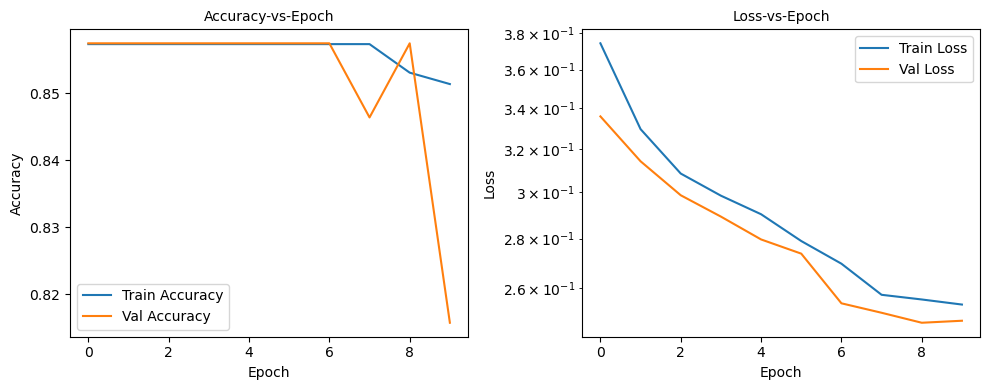

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Subplot 1: accuracy vs epoch
ax[0].plot(history.history['accuracy'],     label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy-vs-Epoch', fontsize=10)
ax[0].legend(loc='best')

# Subplot 2: loss vs epoch
ax[1].plot(history.history['loss'],     label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].legend(loc='best')
ax[1].set_title('Loss-vs-Epoch', fontsize=10)

plt.tight_layout()
#plt.savefig('combined_plot.png')
plt.show()

### Using the trained model to predict

In [11]:
y_predicted_train = model.predict(X_train)
y_predicted_test  = model.predict(X_test)

df_train['score'] = y_predicted_train
df_test['score']  = y_predicted_test

# ROC information for the test dataset
fpr, tpr, _ = roc_curve(y_test, y_predicted_test)
auc_score = auc(tpr,1-fpr)
tpr=tpr*100
fnr=(1-fpr)*100

# ROC information for training data
fpr1, tpr1, _ = roc_curve(y_train, y_predicted_train)
auc_score1 = auc(tpr1,1-fpr1)
tpr1=tpr1*100
fnr1=(1-fpr1)*100

37/37 [==============================] - 0s 4ms/step


In [12]:
display(df_test)

,nlep,lep0_pt,truth,score
0,2,98.094154,1,0.705150
1,2,91.788727,1,0.685502
2,2,46.316006,0,0.527803
3,2,316.621521,1,0.983489
4,2,528.704712,1,0.998049
...,...,...,...,...
1167,2,20.507399,1,0.458916
1168,2,528.225037,1,0.998043
1169,2,705.919739,1,0.999163
1170,2,180.058929,1,0.888734


In [13]:
%%capture

mybins = np.arange(0, 1.02, 0.02)

testsig = plt.hist(df_test[df_test['truth']==1]['score'], bins=mybins, density=False)
counts_sig, bins_sig, _ = testsig
errors_sig = np.sqrt(counts_sig)

testbkg = plt.hist(df_test[df_test['truth']==0]['score'], bins=mybins, density=False)
counts_bkg, bins_bkg, _ = testbkg
errors_bkg = np.sqrt(counts_bkg)

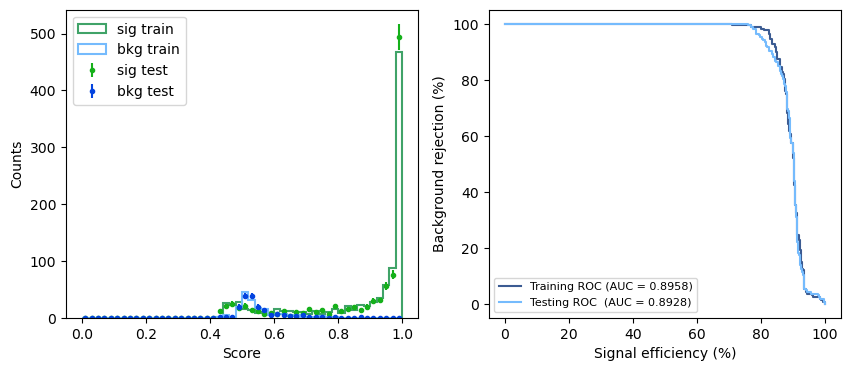

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

decorate_hist = {
    'bins':mybins,
    'histtype':'step',
    'linewidth':1.5,
    'density':False,
    'log':False
}

decorate_point ={
    'marker':'o',
    'markersize':3,
    'linestyle':''
}

ax[0].errorbar(bins_sig[:-1]+np.diff(bins_sig)/2, counts_sig, yerr=errors_sig, color='xkcd:green', label='sig test', **decorate_point)
ax[0].errorbar(bins_bkg[:-1]+np.diff(bins_bkg)/2, counts_bkg, yerr=errors_bkg, color='xkcd:blue',  label='bkg test', **decorate_point)
trainsig = ax[0].hist(df_train[df_train['truth'] == 1]['score'], color='xkcd:greenish', label='sig train', **decorate_hist)
trainbkg = ax[0].hist(df_train[df_train['truth'] == 0]['score'], color='xkcd:sky blue', label='bkg train', **decorate_hist)
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Counts')
ax[0].legend(loc='best')

ax[1].plot(tpr, fnr, color='xkcd:denim blue', label='Training ROC (AUC = %0.4f)' % auc_score)
ax[1].plot(tpr1,fnr1,color='xkcd:sky blue',   label='Testing ROC  (AUC = %0.4f)'  % auc_score1)
ax[1].set_xlabel('Signal efficiency (%)')
ax[1].set_ylabel('Background rejection (%)')
ax[1].legend(loc='best', fontsize=8)

plt.show()